#### Mini Project 3: "Optimizing Sectoral PE Analysis and Algorithmic Trading Strategies

### Introduction:
In the ever-evolving realm of financial markets, it is imperative to delve into the analysis of sector-specific valuation metrics to make well-informed investment decisions. This project centers around the exploration of Price-to-Earnings (PE) dynamics, focusing particularly on the Health and Industrial sectors.I aim to unravel insights into sectoral valuation trends and construct a trading strategy grounded in machine learning principles.

### Let's import the necessary libraries

In [39]:
# Import Libraries
import numpy as np # package for scientific computing
import pandas as pd # package for data manipulation
import os # package for communicating with operating system
import statsmodels.formula.api as smf # package for statistical models i.e. OLS
import scipy.stats as st #open-source library used for scientific and technical computing
import matplotlib.pyplot as plt #plotting library for creating visualizations in Python
import seaborn as sns #import seaborn as sns

### Data description:
In the dataset provided for this analysis, we will be focusing on Price-to-Earnings (PE) ratios, a critical valuation metric calculated by dividing the market price per share by the earnings per share. The PE ratio serves as a key indicator in assessing the relative value of a stock, playing a crucial role in investment decision-making. Additionally, the dataset includes information on returns, indicating the percentage change in value from the previous day.

The data, sourced from the "hw3_data.csv" file available [here](https://github.com/Oishika-Kar/Analysis-of-Sectoral-P-E-and-Implementation-of-Trading-Strategies-Using-Machine-Learning.git) specifically explores PE ratios and returns for both the Industrial and Financial Sectors. Throughout the following questions, we will delve into the intricacies of this dataset to gain insights and derive meaningful conclusions about the valuation dynamics and performance trends within these sectors.

 **Health_PE**: Refers to the Price-to-Earnings (PE) ratio for the Health sector. 

**HealthSector_Returns**: Represents the returns (percentage change) of the Health sector. 

**Industrial_PE**: Similar to "Health_PE," this column represents the Price-to-Earnings (PE) ratio for the Industrial sector.

**IndustrialSector_Returns**: Similar to "HealthSector_Returns," this column represents the returns (percentage change) of the Industrial sector.


In [40]:
# Load the data
data = pd.read_csv('hw3_data.csv', parse_dates = True)
data

,Date,Health_PE,HealthSector_Returns,Industrial_PE,IndustrialSector_Returns
0,1991-04-08,22.0549,-0.014480,15.4770,-0.016236
1,1991-04-09,21.7379,-0.003043,15.2208,-0.008287
2,1991-04-10,21.6718,0.014624,15.2860,0.019911
3,1991-04-11,21.9911,0.005691,15.4244,-0.001905
4,1991-04-12,22.1166,0.003776,15.4863,0.002857
...,...,...,...,...,...
8263,2024-01-26,19.8396,0.006819,21.2431,0.003013
8264,2024-01-29,19.9753,0.002470,21.3780,0.011887
8265,2024-01-30,20.0247,-0.001112,21.3879,-0.012228
8266,2024-01-31,19.9998,0.012589,21.1433,0.000915


### Fisher Transformation:

In this analysis, we employ the Fisher Transformation on the Price-to-Earnings (P/E) ratios, utilizing distinct window sizes for the Health and Industrial Sectors. Specifically, a window size of **756** observations is applied for the Health Sector, while the Industrial Sector undergoes a transformation with a window size of **1764** observations.

The Fisher Transformation is employed to normalize and stabilize the distribution of the P/E ratios, making the data more amenable to statistical analysis. By applying this transformation, we aim to enhance the accuracy and reliability of subsequent analyses, providing a solid foundation for the development of robust trading strategies.

In [41]:
#Rolling window size
s_h = 756
s_i= 1764

In [42]:
# Establish rolling min and max for health:
data['roll_min_h'] = data[['Health_PE']].rolling(int(s_h)).min()
data['roll_max_h'] = data[['Health_PE']].rolling(int(s_h)).max()

# Establish rolling min and max for industrial:  
data['roll_min_i'] = data[['Industrial_PE']].rolling(int(s_i)).min()
data['roll_max_i'] = data[['Industrial_PE']].rolling(int(s_i)).max()

#Fisher Transfomation:
data['fisher_health'] = (data['Health_PE'] - data['roll_min_h']) / (data['roll_max_h'] - data['roll_min_h'])
data['fisher_industrial'] = (data['Industrial_PE'] - data['roll_min_i']) / (data['roll_max_i'] - data['roll_min_i'])

In [43]:
data.tail()

,Date,Health_PE,HealthSector_Returns,Industrial_PE,IndustrialSector_Returns,roll_min_h,roll_max_h,roll_min_i,roll_max_i,fisher_health,fisher_industrial
8263,2024-01-26,19.8396,0.006819,21.2431,0.003013,14.4757,20.1108,11.5304,53.7319,0.951873,0.230151
8264,2024-01-29,19.9753,0.002470,21.3780,0.011887,14.4757,20.1108,11.5304,53.7319,0.975954,0.233347
8265,2024-01-30,20.0247,-0.001112,21.3879,-0.012228,14.4757,20.1108,11.5304,53.7319,0.984721,0.233582
8266,2024-01-31,19.9998,0.012589,21.1433,0.000915,14.4757,20.1108,11.5304,53.7319,0.980302,0.227786
8267,2024-02-01,20.2532,0.001508,21.5030,0.007644,14.4757,20.2532,11.5304,53.7319,1.000000,0.236309


### Building the trading strategy:
This strategy employs a dynamic approach to seize opportunities in the Fisher transformed Price-to-Earnings (PE) of a sector. It systematically decides to "go short" (sell) when the transformed PE drops below a specific level, indicating a potential decline in the sector. Conversely, it chooses to "go long" (buy) when the transformed PE rises above another level, suggesting an expected increase in the sector's performance. Once a position is taken, it remains in the market until a signal in the opposite direction prompts an exit.

We'll be using Python to build and implement this strategy, showcasing a practical example of how computer-based trading methods can be applied to analyze sectoral PE data for better decision-making.

In [44]:
def strategy(u, l, data):
    # Make a copy of the original data set
    data_copy = data.copy()

    # Health sector signals
    data_copy['signal_h'] = np.NaN
    # Enter short position for Health when crossing below upper threshold
    data_copy.loc[(data_copy['fisher_health'].shift() > u) & (data_copy['fisher_health'] < u), 'signal_h'] = -1
    # Enter long position for Health when crossing above lower threshold
    data_copy.loc[(data_copy['fisher_health'].shift() < l) & (data_copy['fisher_health'] > l), 'signal_h'] = 1
    # Forward fill the 'signal_h' column to carry the position forward
    data_copy['signal_h'] = data_copy['signal_h'].ffill()

    # Industrial sector signals
    data_copy['signal_i'] = np.NaN
    # Enter short position for Industrial when crossing below upper threshold
    data_copy.loc[(data_copy['fisher_industrial'].shift() > u) & (data_copy['fisher_industrial']< u), 'signal_i'] = -1
    # Enter long position for Industrial when crossing above lower threshold
    data_copy.loc[(data_copy['fisher_industrial'].shift() < l) & (data_copy['fisher_industrial']> l), 'signal_i'] = 1
    # Forward fill the 'signal_i' column to carry the position forward
    data_copy['signal_i'] = data_copy['signal_i'].ffill()

    return data_copy


In this Python code, we've implemented a trading strategy function called strategy that operates on a given dataset. The function takes three parameters: u (upper threshold), l (lower threshold), and data (the dataset). The dataset is expected to contain columns like 'fisher_health' and 'fisher_industrial', representing the Fisher transformed PE values for the Health and Industrial sectors, respectively.

Here's a breakdown of the strategy:

**Data Copy**: A copy of the original dataset (data_copy) is created to avoid modifying the original data during the strategy execution.
Health Sector Signals:

A new column, **'signal_h'**, is created to store trading signals for the Health sector. A value of -1 is assigned to 'signal_h' when the Fisher transformed PE crosses below the upper threshold, indicating a short position (sell). A value of 1 is assigned to 'signal_h' when the Fisher transformed PE crosses above the lower threshold, indicating a long position (buy).
The 'signal_h' column is forward-filled to carry the position forward until a new signal occurs.
Industrial Sector Signals:

A similar process is applied to the Industrial sector with the creation of the **'signal_i'** column.-1 is assigned for a short position when the Fisher transformed PE crosses below the upper threshold.1 is assigned for a long position when the Fisher transformed PE crosses above the lower threshold. The 'signal_i' column is also forward-filled to carry the position forward.
Return:

The **modified dataset (data_copy)** with the added signal columns is returned.

This strategy function encapsulates the logic for entering short and long positions based on Fisher transformed PE values for the Health and Industrial sectors, with the thresholds **u** and **l** guiding these decisions. This code provides a systematic way to automate trading signals and position management according to the defined thresholds.






### Finding the right combination of thresholds:

 In our pursuit of an optimal trading strategy, we now venture into a comprehensive exploration of hyperparameter combinations for our Fisher transformed Price-to-Earnings (PE) strategies. This involves testing at least 400 different combinations of valid upper and lower thresholds for each Fisher transformed PE series, with the overarching goal of maximizing returns. To gauge the success of each combination, we employ the **geometric mean as our performance metric**.

**Geometric Mean Calculation (geometric_mean function):**

The geometric mean of returns is calculated for both the Health ('GM_h') and Industrial ('GM_i') sectors.
The returns are computed using the trading signals generated by the strategy, combined with the sectoral returns.
The cumulative product of returns is used to calculate the geometric mean for each sector.

In [45]:
def geometric_mean(data_copy): #simple returns has been assumed
    data_copy["return_health"] = (data_copy["signal_h"].shift() * data_copy['HealthSector_Returns'])
    data_copy["return_health"] = data_copy["return_health"].fillna(0)
    data_copy["return_industrial"] = (data_copy["signal_i"].shift() * data_copy['IndustrialSector_Returns'])
    data_copy["return_industrial"] = data_copy["return_industrial"].fillna(0)

    GM_h = ((data_copy['return_health']+1).cumprod().iloc[-1])**(1/len(data_copy['return_health'])) - 1
    GM_i = ((data_copy['return_industrial']+1).cumprod().iloc[-1])**(1/len(data_copy['return_industrial'])) - 1
    return GM_h, GM_i


**Hyperparameter Exploration Loop:**

Two arrays, u1_values and l1_values, are defined to represent the upper and lower thresholds, respectively.
A nested loop iterates through these arrays to test combinations of thresholds for both sectors.
The strategy function is applied to the dataset using each combination of thresholds, generating trading signals.
The geometric mean returns are calculated for the Health and Industrial sectors using the geometric_mean function.
The results, including the hyperparameters and corresponding geometric mean returns, are stored in the 'results' list.

**Results Compilation and Sorting:**

The 'results' list is converted into a DataFrame for easier analysis.
The DataFrame is sorted based on the geometric mean returns for both sectors, in descending order.
Any NaN values are dropped, ensuring only valid and sorted results are retained.

**Scaling Geometric Mean Values:**

To enhance readability, the geometric mean values are multiplied by 10,000 and stored in the DataFrame.

In [46]:
u1_values = np.arange(0, 1, 0.05)  #number of points to ensure at least 400 combinations
l1_values = np.arange(0, 1, 0.05)

results = []

result_data_copy = data.copy()

for u1 in u1_values:
    for l1 in filter(lambda x: x < u1, l1_values):
        print(u1, l1)
        data_copy = strategy(u1, l1, result_data_copy.copy())  # Making sure to pass a copy of the original data
        GM_h, GM_i = geometric_mean(data_copy)
        results.append({'u1': u1, 'l1': l1, 'GM_h': GM_h, 'GM_i': GM_i})

results_data = pd.DataFrame(results)

sorted_results = results_data.sort_values(by=['GM_h', 'GM_i'], ascending=False)
sorted_results = sorted_results.dropna()

sorted_results["GM_h"] = sorted_results["GM_h"] * 10000
sorted_results["GM_i"] = sorted_results["GM_i"] * 10000


0.05 0.0
0.1 0.0
0.1 0.05
0.15000000000000002 0.0
0.15000000000000002 0.05
0.15000000000000002 0.1
0.2 0.0
0.2 0.05
0.2 0.1
0.2 0.15000000000000002
0.25 0.0
0.25 0.05
0.25 0.1
0.25 0.15000000000000002
0.25 0.2
0.30000000000000004 0.0
0.30000000000000004 0.05
0.30000000000000004 0.1
0.30000000000000004 0.15000000000000002
0.30000000000000004 0.2
0.30000000000000004 0.25
0.35000000000000003 0.0
0.35000000000000003 0.05
0.35000000000000003 0.1
0.35000000000000003 0.15000000000000002
0.35000000000000003 0.2
0.35000000000000003 0.25
0.35000000000000003 0.30000000000000004
0.4 0.0
0.4 0.05
0.4 0.1
0.4 0.15000000000000002
0.4 0.2
0.4 0.25
0.4 0.30000000000000004
0.4 0.35000000000000003
0.45 0.0
0.45 0.05
0.45 0.1
0.45 0.15000000000000002
0.45 0.2
0.45 0.25
0.45 0.30000000000000004
0.45 0.35000000000000003


0.45 0.4
0.5 0.0
0.5 0.05
0.5 0.1
0.5 0.15000000000000002
0.5 0.2
0.5 0.25
0.5 0.30000000000000004
0.5 0.35000000000000003
0.5 0.4
0.5 0.45
0.55 0.0
0.55 0.05
0.55 0.1
0.55 0.15000000000000002
0.55 0.2
0.55 0.25
0.55 0.30000000000000004
0.55 0.35000000000000003
0.55 0.4
0.55 0.45
0.55 0.5
0.6000000000000001 0.0
0.6000000000000001 0.05
0.6000000000000001 0.1
0.6000000000000001 0.15000000000000002
0.6000000000000001 0.2
0.6000000000000001 0.25
0.6000000000000001 0.30000000000000004
0.6000000000000001 0.35000000000000003
0.6000000000000001 0.4
0.6000000000000001 0.45
0.6000000000000001 0.5
0.6000000000000001 0.55
0.65 0.0
0.65 0.05
0.65 0.1
0.65 0.15000000000000002
0.65 0.2
0.65 0.25
0.65 0.30000000000000004
0.65 0.35000000000000003
0.65 0.4
0.65 0.45
0.65 0.5
0.65 0.55
0.65 0.6000000000000001
0.7000000000000001 0.0
0.7000000000000001 0.05
0.7000000000000001 0.1
0.7000000000000001 0.15000000000000002
0.7000000000000001 0.2
0.7000000000000001 0.25
0.7000000000000001 0.30000000000000004
0.7

In [47]:
sorted_results.dropna()

,u1,l1,GM_h,GM_i
27,0.35,0.30,0.873051,-2.507838
14,0.25,0.20,0.822049,-0.425975
77,0.60,0.55,0.769378,-0.727629
33,0.40,0.25,0.698901,-2.155314
34,0.40,0.30,0.609279,-2.016938
...,...,...,...,...
21,0.35,0.00,-4.019089,-2.231039
3,0.15,0.00,-4.207418,-2.454894
15,0.30,0.00,-4.232335,-2.221700
6,0.20,0.00,-4.266324,-2.410998


In [61]:
from IPython.display import display, Markdown

###  Hyperparameter analysis and heat map:

Hyperparameter analysis helps identify the threshold values (u1 and l1) that yield the highest geometric mean returns for the Health and Industrial sectors. This information is crucial for fine-tuning the strategy and maximizing profitability.

The heatmap provides a graphical representation of how different hyperparameter combinations affect the geometric mean returns. It allows for a quick and intuitive understanding of the relationships between hyperparameters and strategy performance, aiding in decision-making during strategy optimization.

In [62]:
max_GM_h_index = sorted_results['GM_h'].idxmax()
max_GM_i_index = sorted_results['GM_i'].idxmax()

# Extract the corresponding hyperparameters and GM values
best_hyperparameters_h = sorted_results.loc[max_GM_h_index, ['u1', 'l1', 'GM_h']]
best_hyperparameters_i = sorted_results.loc[max_GM_i_index, ['u1', 'l1', 'GM_i']]

display(Markdown("**Best Hyperparameters for Health:**"))
display(best_hyperparameters_h)

display(Markdown("**Best Hyperparameters for Industrial:**"))
display(best_hyperparameters_i)

**Best Hyperparameters for Health:**

u1      0.350000
l1      0.300000
GM_h    0.873051
Name: 27, dtype: float64

**Best Hyperparameters for Industrial:**

u1      0.700000
l1      0.550000
GM_i    2.035046
Name: 102, dtype: float64

In [50]:
def heatmap(x, y, metric, values, title):
    
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).mean(),1)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)

    # make plot
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(heat, fmt='.1g')
    ax.set_title(title,size = 18)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale=1)
    plt.show()

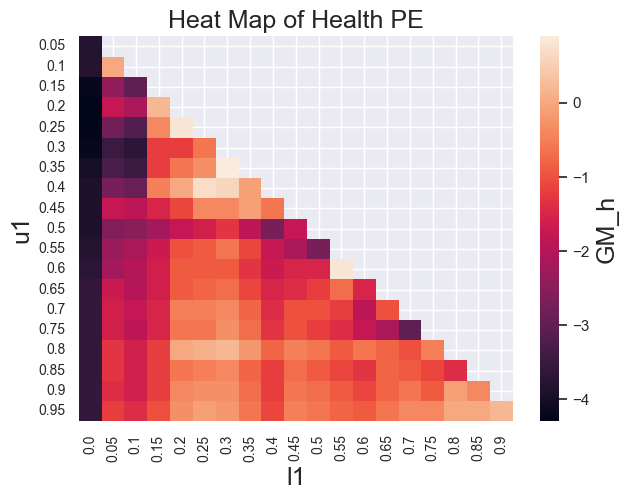

In [51]:
tmp = sorted_results
heatmap("u1", "l1","GM_h", tmp,'Heat Map of Health PE')

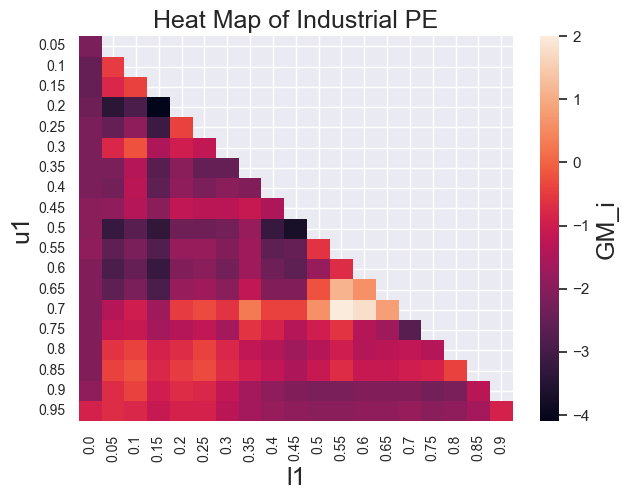

In [52]:
tmp = sorted_results
heatmap("u1", "l1","GM_i", tmp,'Heat Map of Industrial PE')

#### What do the heatmaps tell us about the hyperparameters that are best for each sector?

Best hyperparameters sector wise -
For Health sector, u1 = 0.35 and l1 =  0.30
For Industrial sector u1 = 0.70 and l1 = 0.55

For health sector u1 and l1 are almost same. For industrial sector, there appears to be a significant difference between u1 and l1. In case of health sector when u1 and l1 both are low, GM is highest. In case of industrial sector, when u1 and l1 are increasing slightly in magnitude, we get highest GM.

In [53]:
data.columns

Index(['Date', 'Health_PE', 'HealthSector_Returns', 'Industrial_PE',
       'IndustrialSector_Returns', 'roll_min_h', 'roll_max_h', 'roll_min_i',
       'roll_max_i', 'fisher_health', 'fisher_industrial'],
      dtype='object')

#### Based on what we learned from the heatmaps, we pick a pair of hyperparameters for the health and industrial sector strategies and visualize the equity curve they produce for each.

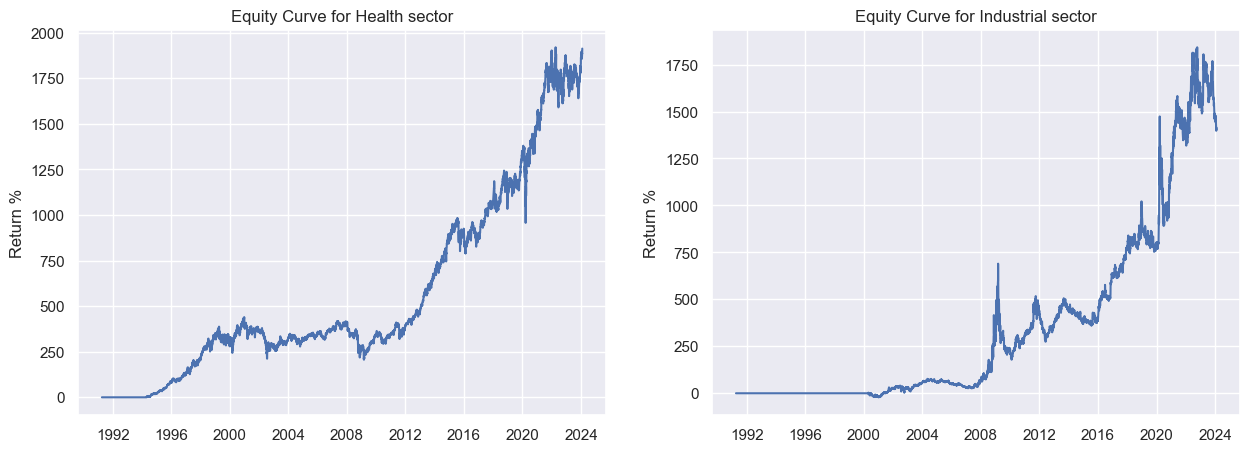

In [54]:
u1, l1 = 1, 0.3
u2, l2 = 0.7, 0.55

# Health sector strategy
data_copy_new_h = strategy(u1, l1, data.copy())
data_copy_new_h['Date'] = pd.to_datetime(data_copy_new_h['Date'])
data_copy_new_h.set_index('Date', inplace=True)
data_copy_new_h["strat_returns_h"] = (data_copy_new_h["signal_h"].shift() * data_copy_new_h['HealthSector_Returns'])
data_copy_new_h["strat_returns_h"] = data_copy_new_h["strat_returns_h"].fillna(0)
data_copy_new_h["cumulative_returns_h"] = (np.exp(data_copy_new_h['strat_returns_h'].cumsum()) - 1) * 100

# Industrial sector strategy
data_copy_new_i = strategy(u2, l2, data.copy())
data_copy_new_i['Date'] = pd.to_datetime(data_copy_new_i['Date'])
data_copy_new_i.set_index('Date', inplace=True)
data_copy_new_i["strat_returns_i"] = (data_copy_new_i["signal_i"].shift() * data_copy_new_i['IndustrialSector_Returns'])
data_copy_new_i["strat_returns_i"] = data_copy_new_i["strat_returns_i"].fillna(0)
data_copy_new_i["cumulative_returns_i"] = (np.exp(data_copy_new_i['strat_returns_i'].cumsum()) - 1) * 100

# Plotting side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(data_copy_new_h.cumulative_returns_h)
plt.ylabel('Return %')
plt.title('Equity Curve for Health sector')

plt.subplot(1, 2, 2)
plt.plot(data_copy_new_i.cumulative_returns_i)
plt.ylabel('Return %')
plt.title('Equity Curve for Industrial sector')

plt.show()


### Portfolio creation

Using the outcomes generated above we create an equally weighted portfolio of returns.

The portfolio DataFrame represents the equally weighted portfolio returns, combining the returns from the trading strategies applied to the Health and Industrial sectors. The resulting portfolio returns aim to provide a consolidated view of the overall performance of the combined strategies

In [55]:
portfolio = pd.DataFrame({"strat_returns": []})

# Combine the strategy returns and calculate the equally weighted portfolio returns
portfolio["strat_returns"] = (data_copy_new_h["strat_returns_h"].fillna(0) + data_copy_new_i["strat_returns_i"].fillna(0)) / 2



In [56]:
portfolio

,strat_returns
Date,
1991-04-08,0.000000
1991-04-09,0.000000
1991-04-10,0.000000
1991-04-11,0.000000
1991-04-12,0.000000
...,...
2024-01-26,0.001903
2024-01-29,-0.004708
2024-01-30,0.005558


### Equity curve of Equally Weighted Portfolio

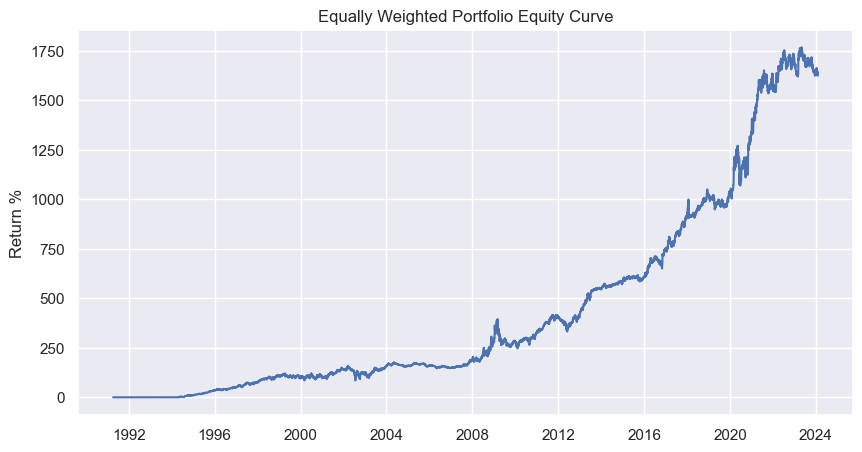

In [57]:
# Calculate the cumulative returns of the equally weighted portfolio
portfolio["cumulative_returns"] = (np.exp(portfolio['strat_returns'].cumsum()) - 1) * 100

# Plot the equity curve for the equally weighted portfolio
plt.figure(figsize=(10, 5))
plt.plot(portfolio["cumulative_returns"])
plt.ylabel('Return %')
plt.title('Equally Weighted Portfolio Equity Curve')

plt.show()

### Evaluating Portfolio Performance: CCRor and Annualized Returns Comparison
In assessing the effectiveness of our portfolio against each sector, we employ two key metrics: CCRor (Cumulative Compound Return over a specified period) and Annualized Returns. These metrics serve as essential indicators of the portfolio's overall performance and its comparative success in relation to each sector.


### CCRor (Cumulative Compound Return):

CCRor represents the cumulative growth of the portfolio over a given time frame. It encapsulates the total return generated by the portfolio, factoring in both positive and negative changes in value. A higher CCRor value signifies greater cumulative growth.
Annualized Returns:

### Annualized Returns: 

This metric allows for a standardized comparison by expressing returns as an annual percentage. Comparing the annualized returns of the portfolio against each sector provides insights into its relative performance over the long term.
By analyzing these metrics, we gain a comprehensive understanding of how our portfolio performed against individual sectors, enabling us to make informed decisions and adjustments to optimize overall investment outcomes.

In [64]:
# Calculate CCRoR for Health Sector
t_h = len(data_copy_new_h) / 252
A_h = data_copy_new_h["cumulative_returns_h"].iloc[-1] + 1
ccror_h = (np.log(A_h) / t_h) * 100

# Calculate CCRoR for Industrial Sector
t_i = len(data_copy_new_i) / 252
A_i = data_copy_new_i["cumulative_returns_i"].iloc[-1] + 1
ccror_i = (np.log(A_i) / t_i) * 100

# Calculate CCRoR for the Equally Weighted Portfolio
t_portfolio = len(portfolio) / 252
A_portfolio = portfolio["cumulative_returns"].iloc[-1] + 1
ccror_portfolio = (np.log(A_portfolio) / t_portfolio) * 100

print("CCRoR:")
print(f"Health Sector: {ccror_h:.2f}%")
print(f"Industrial Sector: {ccror_i:.2f}%")
print(f"Equally Weighted Portfolio: {ccror_portfolio:.2f}%\n")

# Calculate Annualized Returns for Health Sector
AR_h = ((A_h ** (1 / t_h)) - 1) * 100

# Calculate Annualized Returns for Industrial Sector
AR_i = ((A_i ** (1 / t_i)) - 1) * 100

# Calculate Annualized Returns for the Equally Weighted Portfolio
AR_portfolio = ((A_portfolio ** (1 / t_portfolio)) - 1) * 100

print("Annualized Returns:")
print(f"Health Sector: {AR_h:.2f}%")
print(f"Industrial Sector: {AR_i:.2f}%")
print(f"Equally Weighted Portfolio: {AR_portfolio:.2f}%")


CCRoR:
Health Sector: 23.03%
Industrial Sector: 22.09%
Equally Weighted Portfolio: 22.56%

Annualized Returns:
Health Sector: 25.90%
Industrial Sector: 24.72%
Equally Weighted Portfolio: 25.31%


The portfolio, though not achieving the same level of risk-adjusted returns as the Health Sector, is able to outperform the Industrial Sector in terms of CCRoR. The balanced nature of the portfolio helps in achieving a risk-return profile between the two sectors. The portfolio, while not reaching the same level of annualized returns as the Health Sector, still provides a higher return compared to the Industrial Sector. The diversification benefits of the portfolio contribute to achieving a balance in overall annualized returns

### Visualizing Cumulative Returns: Sector-wise and Equally Weighted Portfolio
In this section, we create visual representations of the cumulative returns for each sector as well as the equally weighted portfolio. The cumulative returns illustrate the aggregated performance of each sector and the combined performance of the portfolio over the specified time frame.

**Sector-wise Cumulative Returns:** Visualizing cumulative returns for individual sectors provides a clear insight into the historical performance of each sector. This analysis allows for the comparison of growth trends and volatility among sectors.
Equally Weighted Portfolio:

**Cumulative returns of the equally weighted portfolio**: This showcases the overall performance of the combined strategies applied to different sectors. This visualization aids in assessing how the portfolio's returns evolve over time and provides a holistic view of its effectiveness.

By plotting these cumulative returns, we enhance our understanding of the relative strengths and weaknesses of individual sectors and the collective impact of our trading strategies on the portfolio's overall performance.

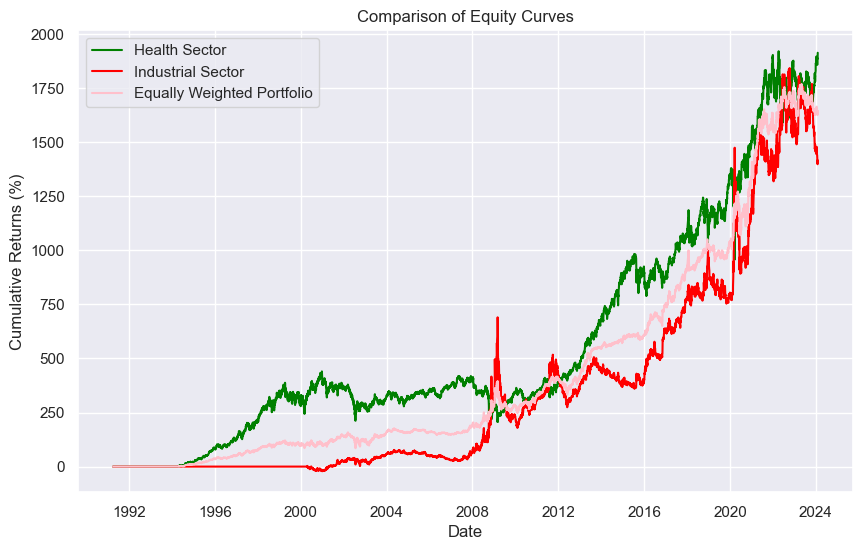

In [59]:
plt.figure(figsize=(10, 6))

# Health Sector
plt.plot(data_copy_new_h.index, data_copy_new_h['cumulative_returns_h'], label='Health Sector', linestyle='-', color='green')

# Industrial Sector
plt.plot(data_copy_new_i.index, data_copy_new_i['cumulative_returns_i'], label='Industrial Sector', linestyle='-', color='red')

# Equally Weighted Portfolio
plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Equally Weighted Portfolio', linestyle='-', color='pink')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.title('Comparison of Equity Curves')
plt.legend()
plt.grid(True)
plt.show()



#### As we can see, Portfolio performs better than Industrial Sector but worse than Health Sector.